In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")
include(pathtorepo * "dynamical-systems\\system.jl")
include(pathtorepo * "dynamical-systems\\visual_regimes.jl");

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`

In [2]:
using StaticArrays, DifferentialEquations, DynamicalSystems, JLD
E, x, y  = -40..40, -5..5,  -5..5
box = E × x × y
using CairoMakie, GLMakie
using LinearAlgebra

In [10]:
function local_min(tr, trange)
    
    localmin = Float64[]
    placeintime = Float64[]
    idxs = Int64[]
    for idx in range(2, length(tr) - 1, step = 1)
        if tr[idx-1] > tr[idx] < tr[idx+1]
            push!(localmin, tr[idx])
            push!(placeintime, trange[idx])
            push!(idxs, idx)
        end
    end
    return localmin, placeintime, idxs
end

function local_max(tr, trange)
    
    localmax= Float64[]
    placeintime = Float64[]
    idxs = Int64[]
    for idx in range(2, length(tr) - 1, step = 1)
        if tr[idx-1] < tr[idx] > tr[idx+1]
            push!(localmax, tr[idx])
            push!(placeintime, trange[idx])
            push!(idxs, idx)
        end
    end
    return localmax, placeintime, idxs
end

function border_burst(lcmin, placeintime, idxs)

    glob_min = Float64[]
    time_glob_min = Float64[]
    idxs_glob_min = Int64[]

    real_glob_min = floor(minimum(lcmin), digits = 2) + 0.5

    for idx in range(2, length(lcmin) - 1, step = 1)
        if lcmin[idx] <= real_glob_min
            push!(glob_min, lcmin[idx])
            push!(time_glob_min, placeintime[idx])
            push!(idxs_glob_min, idxs[idx])
        end
    end
    
    return glob_min, time_glob_min, idxs_glob_min
end

function number_spike_in_burst(data)
    sol, trange = data
    # detect local minimum
    lcmin, place_time, idxs = local_min(sol[:, 1], trange)

    # detect border burst
    glob_min, time_glob_min, idxs_glob_min = border_burst(lcmin, place_time, idxs)

    # check uneven number
    if iseven(length(glob_min)) == false
        deleteat!(glob_min, length(glob_min))
        deleteat!(idxs_glob_min, length(idxs_glob_min))
    end

    number_of_spike = detect_number_spike(glob_min, time_glob_min, idxs_glob_min)

    return number_of_spike
end

function detect_number_spike(glob_min, time_glob_min, idxs_glob_min)


    number_spike = Float64[]
    number_burst = length(glob_min)

    for i in range(1, number_burst-1)
        lcmax, _ = local_max(sol[idxs_glob_min[i]:idxs_glob_min[i+1], 1], trange[idxs_glob_min[i]:idxs_glob_min[i+1]])
        append!(number_spike, length(lcmax))
    end

    maximum(number_spike)

end

detect_number_spike (generic function with 1 method)

In [11]:
cd("C:\\Users\\Alex\\Desktop\\dynamical-systems\\Tsodyks Markram\\Levanova\\3 набор параметров\\Сопоставление с матконт\\файлы matlab")
I0_hom = load("I0_hom_hom.jld")["data"]
u0_hom = load("U0_hom_hom.jld")["data"]
I0_hom = I0_hom[:]
U0_hom = u0_hom[:];

In [12]:
const τ = 0.013;  const τD = 0.07993;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4; const α = 1.58; const ΔU0 = 0.305;

In [13]:
time = 1000; tt = 1000; tstep = 0.001; times = [time, tt]
integ_set = (alg = Vern9(), adaptive = false, dt = tstep);

In [14]:
index_dot = 10
I0_hom_dot = I0_hom[index_dot]
U0_hom_dot = U0_hom[index_dot]

println("I0: ", I0_hom[index_dot])
println("U0: ", U0_hom[index_dot])

I0: -1.706602442139903
U0: 0.2650227397981071


In [15]:
#I0 = I0_hom_dot; U0 = U0_hom_dot
I0 = -1.7012; U0 = 0.265

p = SA[α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]
u0_1 = [4.304585360890702, 0.8496103655419769, 0.46185811359095336]
# [8.421422866701183, 0.7359215519694303, 0.43895581827508423]

ds = CoupledODEs(TM, u0_1, p, diffeq = integ_set)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  TM
 ODE solver:    Vern9
 ODE kwargs:    (adaptive = false, dt = 0.001)
 parameters:    [1.58, 0.013, 0.07993, 3.3, 3.07, 0.75, 0.4, 0.265, 0.305, 0.3, -1.7012]
 time:          0.0
 state:         [4.304585360890702, 0.8496103655419769, 0.46185811359095336]


In [16]:
fp, ei, _ = fixedpoints(ds, box, jacob_TM_);
sol, trange = trajectory(ds, time, Ttr = tt*2, Δt = tstep )

data = [sol, trange]
number_spike_in_burst(data)

1178.0

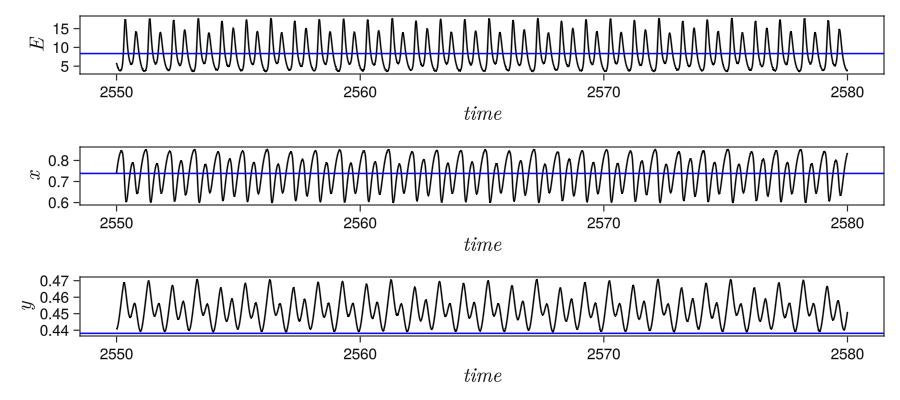

In [17]:
ts, tf = 550000, 580000
lb_size_ts = 20
tck_size_ts = 15
f = Figure(resolution = (900, 400))

axisE = Axis(f[1, 1], xlabel = L"$time$", ylabel = L"$E$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)
axisx = Axis(f[2, 1], xlabel = L"$time$", ylabel = L"$x$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)
axisy = Axis(f[3, 1], xlabel = L"$time$", ylabel = L"$y$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)

lines!(axisE, trange[ts:tf], sol[ts:tf, 1], linewidth = 1.5, color = :black)
hlines!(axisE, fp[1][1], color = :blue)

lines!(axisx, trange[ts:tf], sol[ts:tf, 2], linewidth = 1.5, color = :black)
hlines!(axisx, fp[1][2], color = :blue)

lines!(axisy, trange[ts:tf], sol[ts:tf, 3], linewidth = 1.5, color = :black)
hlines!(axisy, fp[1][3], color = :blue)
#ylims!(axisy, 0.425, 0.48)
f

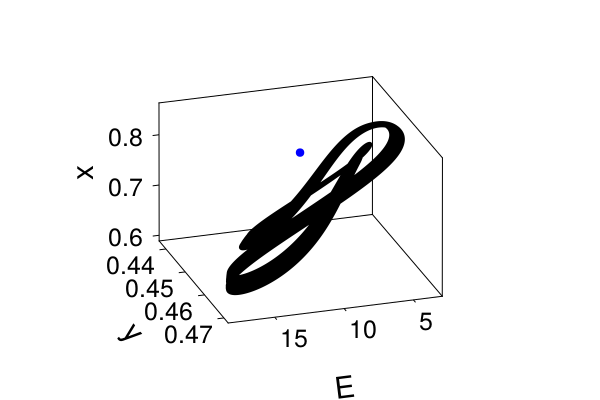

CairoMakie.Screen{IMAGE}


In [18]:
ts, tf = 450000, 480000
idx, idy, idz = 1, 3, 2
lb_size = 30; tck_size = 25;
dis  = 60;

CairoMakie.activate!()
f = Figure(resolution = (600, 400))
ax = Axis3(f[1, 1], azimuth = 0.4pi,
            xlabel = "E", ylabel = "y", zlabel = "x",
            xlabelsize = lb_size, ylabelsize = lb_size, zlabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size, zticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false, zgridvisible = false,
            protrusions = dis, xlabeloffset = dis, ylabeloffset = dis, zlabeloffset = dis)

#ax = LScene(f[1, 1])
#scale!(ax.scene, 1, 50, 50)

lines!(sol[ts:tf, idx], sol[ts:tf, idy], sol[ts:tf, idz],
    linewidth = 3.0, color = :black)

for (i, ep) in enumerate(fp)
    scatter!(ep[idx], ep[idy], ep[idz], color = :blue, markersize = 12)
end

display(f)

# Алгоритм вне функций

In [20]:
lcmin, place_time, idxs = local_min(sol[:, 1], trange)
#glob_min, time_glob_min, idxs_glob_min = border_burst(lcmin, place_time, idxs)

if iseven(length(glob_min)) == false
    deleteat!(glob_min, length(glob_min))
    deleteat!(idxs_glob_min, length(idxs_glob_min))
end

In [31]:
# Border burst
glob_min = Float64[]
time_glob_min = Float64[]
idxs_glob_min = Int64[]

real_glob_min = floor(minimum(lcmin), digits = 2) +0.2

for idx in range(2, length(lcmin) - 1, step = 1)
    if lcmin[idx] <= real_glob_min
        push!(glob_min, lcmin[idx])
        push!(time_glob_min, place_time[idx])
        push!(idxs_glob_min, idxs[idx])
    end
end

In [191]:
number_spike = Float64[]

Float64[]

In [192]:
number_burst = length(glob_min)

28

In [193]:
for i in range(1, number_burst-1)
    lcmax, _ = local_max(sol[idxs_glob_min[i]:idxs_glob_min[i+1], 1], trange[idxs_glob_min[i]:idxs_glob_min[i+1]])
    append!(number_spike, length(lcmax))
end

In [194]:
maximum(number_spike)

1178.0

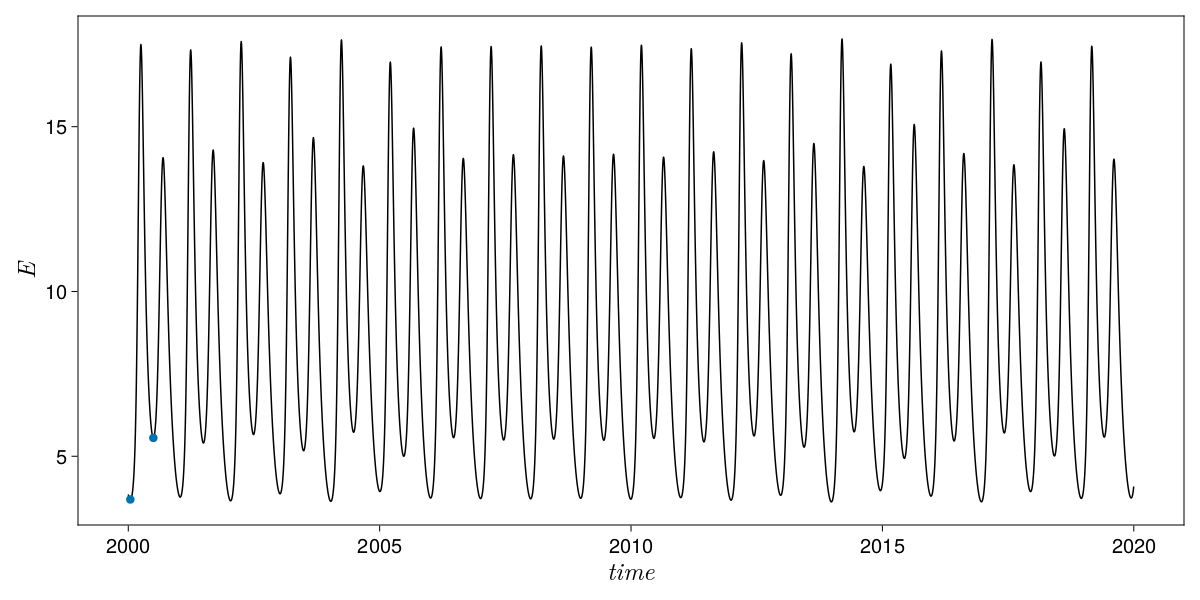

In [29]:
ts, tf = 1, 20000 # idxs_glob_min[idxstart], idxs_glob_min[idxend]

lb_size_ts = 25
tck_size_ts = 20

idxstart, idxend = 1, 2
f = Figure(resolution = (1200, 600))

axisE = Axis(f[1, 1], xlabel = L"$time$", ylabel = L"$E$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)

lines!(axisE, trange[ts:tf], sol[ts:tf, 1], linewidth = 1.5, color = :black)

scatter!(place_time[idxstart:idxend], lcmin[idxstart:idxend])

#scatter!(time_glob_min[idxstart:idxend], glob_min[idxstart:idxend])
f

In [34]:
place_time[1:2], lcmin[1:2]

([2000.041, 2000.499], [3.6881304445545093, 5.555722893778432])

In [35]:
time_glob_min[1:2], glob_min[1:2]

([2122.156, 2126.39], [1.3807334311246646, 1.362141958112477])